### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
model_name = 'exp-model-07-keras-embedding-small-baseline'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
is_embedding = True
is_tar_encoded = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

# cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

rare_village_threshold = 1
rare_town_threshold = 1

print('Target:', col_target)

Target: log_per_area_total_price


### Columns

In [4]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

cols_num = [c for c in cols_num if c not in cols_feats_rm]
cols_bin = [c for c in cols_bin if c not in cols_feats_rm]
cols_cat = [c for c in cols_cat if c not in cols_feats_rm]

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

# right skew cols
#cols_right_skew = ['parking_area', 'land_area', 'building_area']+[c for c in cols_num if 'MIN' in c]

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add))
#print('Right skew:', cols_right_skew)
#print('Total:', len(cols_feats))

Num: 155 Bin: 49 Cat: 7
Add: 1 0 1


### Read data

In [5]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)
train.head(5)
test.head(5)

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv(f'dataset/id_cv{i}.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

### Preprocessing

In [6]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
    # label for stratified train test split
    #df['stratified'] = 
    
    return df

In [7]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
        
    return y_pred_final

In [8]:
train = pre_processing(train, cols_num, cols_cat, cols_bin)
test = pre_processing(test, cols_num, cols_cat, cols_bin)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', len(cols_feats))

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat] if is_tar_encoded else []
    
print('\nTarget mean encoded columns:', len(cols_tar_encoded))

# Compute skew columns
cols_right_skew = [c for c in cols_num if train[c].skew() > 2.2]
print('\nRight skew columns:', len(cols_right_skew))

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
    #'village_income_median': 'median',
}

Feat columns: 213

Target mean encoded columns: 0

Right skew columns: 77


### Feature engineering
Include cat encoding, fillna, scaling

In [10]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [11]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False, is_tar_encoded=True,
                 n_ran_encode=4, rare_village_threshold=1, rare_town_threshold=1):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Cat encoders
        self.is_tar_encoded = is_tar_encoded
        if is_tar_encoded:
            self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras', reserve_missing=True)
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
        # Rare village and town threshold
        self.rare_village_threshold = rare_village_threshold
        self.rare_town_threshold = rare_town_threshold
        
    def fit_transform(self, df, df_test):
        df = df.copy()
        
        # Rare village and town
        train_towns = df['town'].value_counts()
        rare_towns = (set(train_towns.index[train_towns <= self.rare_town_threshold])
                      - set(df_test['town']))
        df.loc[df['town'].isin(rare_towns), 'town'] = np.nan
        
        train_villages = df['village'].value_counts()        
        rare_villages = (set(train_villages.index[train_villages <= self.rare_village_threshold])
                         - set(df_test['village']))
        df.loc[df['village'].isin(rare_villages), 'village'] = np.nan        
        
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
            self.cols_tar_encoded = [c for c in df_tar_encoded]
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        else:
            self.cols_tar_encoded = []
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        assert self.col_target in df, 'Target column not found in the dataframe'
        self.target_scaler.fit(df, cols=[self.col_target])
        self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

### Keras Model

In [12]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, concatenate
from keras.optimizers import Adam, SGD
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


keras: 2.2.2 tensorflow: 1.10.1


In [13]:
from keras_get_best import GetBest

def build_model(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=(1024,)*7, learning_rate=0.001, optimizer=Adam):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    is_embedding = len(cat_n_classes) > 0
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    if is_embedding:
        cats_embedding_layers = [
            Reshape(target_shape=(cat_embed_sizes[c],))(
                Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
            ) 
            for c, c_input_dim in cat_n_classes.items()
        ]
        x_layer = concatenate([num_bin_input]+cats_embedding_layers)  # output shape = 258
    else:
        x_layer = num_bin_input
    for n in n_neurons:
        x_layer = Dense(n, activation='relu')(x_layer)
    output = Dense(1)(x_layer)
    model = Model(inputs=[num_bin_input]+list(cats_inputs.values()),
                  outputs=output)
    model.compile(optimizer=optimizer(lr=learning_rate), loss='mae', metrics=['mse'])
    return model    

def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

def plot_keras_hist(hists, ylim=None, metrics_plot=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].history.keys() if not c.startswith('val')]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for i, hist in enumerate(hists):
            for c in hist.history:
                if c.endswith(m):
                    plt.plot(hist.history[c], label=c+' '+str(i), alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

### Params

In [14]:
params = {'epochs': 200,
          'n_neurons': (512,)*3+(256,)*4,
          'optimizer': Adam,
          'learning_rate': 0.001,
          'batch_size': 64,
         }

### kfold cross-predict

In [15]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
hists = []
best_iterations = []
scores = []
for i, id_fold in enumerate(id_cv):
    print('==== Fold', i+1, '====')
    
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_val = train.loc[train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_test = test.copy()

    # Feature engineering
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,
                                  rare_village_threshold=rare_village_threshold, 
                                  rare_town_threshold=rare_town_threshold,)
    df_train = feat_eng.fit_transform(df_train, df_val)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)

    # Construct X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
        cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
    else:
        cat_n_classes = {}
        cat_embed_sizes = {}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

    # Build model
    model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, 
                        n_neurons=params['n_neurons'], learning_rate=params['learning_rate'], 
                        optimizer=params['optimizer'])

    # Train model
    hist = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'], 
                     verbose=2, validation_data=(X_val, y_val), 
                     callbacks=[GetBest(monitor='val_loss', verbose=0, mode='min')])
    best_iterations.append(np.argmin(hist.history['val_loss'])+1)
    hists.append(hist)

    # Predict on val set
    df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)
    feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
    df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)

    mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
    mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
    mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
    score = cal_score(df_val['total_price'], df_val['total_price_pred'])
    scores.append(score)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': df_val['total_price_pred']}))

    
    # Predict on test set
    df_test[col_target+'_scaled_pred'] = model.predict(X_test, batch_size=1024)
    feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')

    predicts_test['target_{}'.format(i)] = df_test[col_target+'_pred']

t1 = time.time()

==== Fold 1 ====
Numerical input dims: 205
Embeding  input dims: {'building_material': 10, 'city': 12, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'town': 209, 'village': 2606, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'city': 6, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'town': 11, 'village': 16, 'encoded_latlon': 5}
Total embedding output dims: 56
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
 - 8s - loss: 0.2605 - mean_squared_error: 0.1279 - val_loss: 0.2320 - val_mean_squared_error: 0.0959
Epoch 2/200
 - 8s - loss: 0.2069 - mean_squared_error: 0.0820 - val_loss: 0.1959 - val_mean_squared_error: 0.0748
Epoch 3/200
 - 7s - loss: 0.1889 - mean_squared_error: 0.0701 - val_loss: 0.1871 - val_mean_squared_error: 0.0683
Epoch 4/200
 - 7s - loss: 0.1785 - mean_squared_error: 0.0645 - val_loss: 0.1869 - val_mean_squared_error: 0.0705
Epoch 5/200
 - 7s - loss: 0.1689 - mean_squared_error: 0.0580 - val_loss: 0.1769 - val_

Epoch 69/200
 - 8s - loss: 0.0524 - mean_squared_error: 0.0081 - val_loss: 0.1545 - val_mean_squared_error: 0.0530
Epoch 70/200
 - 8s - loss: 0.0519 - mean_squared_error: 0.0080 - val_loss: 0.1558 - val_mean_squared_error: 0.0540
Epoch 71/200
 - 8s - loss: 0.0509 - mean_squared_error: 0.0078 - val_loss: 0.1552 - val_mean_squared_error: 0.0533
Epoch 72/200
 - 8s - loss: 0.0508 - mean_squared_error: 0.0077 - val_loss: 0.1568 - val_mean_squared_error: 0.0543
Epoch 73/200
 - 8s - loss: 0.0501 - mean_squared_error: 0.0075 - val_loss: 0.1581 - val_mean_squared_error: 0.0549
Epoch 74/200
 - 8s - loss: 0.0500 - mean_squared_error: 0.0074 - val_loss: 0.1540 - val_mean_squared_error: 0.0525
Epoch 75/200
 - 8s - loss: 0.0504 - mean_squared_error: 0.0083 - val_loss: 0.1546 - val_mean_squared_error: 0.0532
Epoch 76/200
 - 8s - loss: 0.0491 - mean_squared_error: 0.0073 - val_loss: 0.1544 - val_mean_squared_error: 0.0533
Epoch 77/200
 - 8s - loss: 0.0485 - mean_squared_error: 0.0071 - val_loss: 0.155

Epoch 140/200
 - 7s - loss: 0.0331 - mean_squared_error: 0.0038 - val_loss: 0.1546 - val_mean_squared_error: 0.0533
Epoch 141/200
 - 7s - loss: 0.0328 - mean_squared_error: 0.0037 - val_loss: 0.1548 - val_mean_squared_error: 0.0536
Epoch 142/200
 - 7s - loss: 0.0326 - mean_squared_error: 0.0036 - val_loss: 0.1527 - val_mean_squared_error: 0.0526
Epoch 143/200
 - 7s - loss: 0.0328 - mean_squared_error: 0.0037 - val_loss: 0.1541 - val_mean_squared_error: 0.0536
Epoch 144/200
 - 7s - loss: 0.0326 - mean_squared_error: 0.0037 - val_loss: 0.1535 - val_mean_squared_error: 0.0532
Epoch 145/200
 - 7s - loss: 0.0324 - mean_squared_error: 0.0036 - val_loss: 0.1532 - val_mean_squared_error: 0.0529
Epoch 146/200
 - 7s - loss: 0.0322 - mean_squared_error: 0.0036 - val_loss: 0.1530 - val_mean_squared_error: 0.0526
Epoch 147/200
 - 7s - loss: 0.0322 - mean_squared_error: 0.0037 - val_loss: 0.1532 - val_mean_squared_error: 0.0526
Epoch 148/200
 - 7s - loss: 0.0328 - mean_squared_error: 0.0037 - val_lo

Epoch 7/200
 - 7s - loss: 0.1551 - mean_squared_error: 0.0501 - val_loss: 0.1718 - val_mean_squared_error: 0.0601
Epoch 8/200
 - 7s - loss: 0.1506 - mean_squared_error: 0.0481 - val_loss: 0.1689 - val_mean_squared_error: 0.0594
Epoch 9/200
 - 7s - loss: 0.1461 - mean_squared_error: 0.0456 - val_loss: 0.1665 - val_mean_squared_error: 0.0578
Epoch 10/200
 - 7s - loss: 0.1413 - mean_squared_error: 0.0433 - val_loss: 0.1698 - val_mean_squared_error: 0.0586
Epoch 11/200
 - 8s - loss: 0.1362 - mean_squared_error: 0.0405 - val_loss: 0.1733 - val_mean_squared_error: 0.0614
Epoch 12/200
 - 8s - loss: 0.1330 - mean_squared_error: 0.0392 - val_loss: 0.1778 - val_mean_squared_error: 0.0635
Epoch 13/200
 - 7s - loss: 0.1288 - mean_squared_error: 0.0370 - val_loss: 0.1652 - val_mean_squared_error: 0.0571
Epoch 14/200
 - 7s - loss: 0.1258 - mean_squared_error: 0.0356 - val_loss: 0.1829 - val_mean_squared_error: 0.0656
Epoch 15/200
 - 7s - loss: 0.1221 - mean_squared_error: 0.0338 - val_loss: 0.1665 -

Epoch 79/200
 - 7s - loss: 0.0475 - mean_squared_error: 0.0070 - val_loss: 0.1584 - val_mean_squared_error: 0.0554
Epoch 80/200
 - 7s - loss: 0.0480 - mean_squared_error: 0.0070 - val_loss: 0.1570 - val_mean_squared_error: 0.0552
Epoch 81/200
 - 7s - loss: 0.0466 - mean_squared_error: 0.0068 - val_loss: 0.1571 - val_mean_squared_error: 0.0551
Epoch 82/200
 - 7s - loss: 0.0473 - mean_squared_error: 0.0069 - val_loss: 0.1562 - val_mean_squared_error: 0.0551
Epoch 83/200
 - 7s - loss: 0.0466 - mean_squared_error: 0.0067 - val_loss: 0.1572 - val_mean_squared_error: 0.0551
Epoch 84/200
 - 7s - loss: 0.0463 - mean_squared_error: 0.0067 - val_loss: 0.1561 - val_mean_squared_error: 0.0548
Epoch 85/200
 - 7s - loss: 0.0456 - mean_squared_error: 0.0065 - val_loss: 0.1579 - val_mean_squared_error: 0.0555
Epoch 86/200
 - 7s - loss: 0.0450 - mean_squared_error: 0.0068 - val_loss: 0.1582 - val_mean_squared_error: 0.0554
Epoch 87/200
 - 8s - loss: 0.0449 - mean_squared_error: 0.0064 - val_loss: 0.156

Epoch 150/200
 - 7s - loss: 0.0319 - mean_squared_error: 0.0040 - val_loss: 0.1574 - val_mean_squared_error: 0.0555
Epoch 151/200
 - 7s - loss: 0.0313 - mean_squared_error: 0.0035 - val_loss: 0.1553 - val_mean_squared_error: 0.0548
Epoch 152/200
 - 7s - loss: 0.0316 - mean_squared_error: 0.0035 - val_loss: 0.1560 - val_mean_squared_error: 0.0552
Epoch 153/200
 - 8s - loss: 0.0318 - mean_squared_error: 0.0038 - val_loss: 0.1557 - val_mean_squared_error: 0.0551
Epoch 154/200
 - 7s - loss: 0.0315 - mean_squared_error: 0.0034 - val_loss: 0.1557 - val_mean_squared_error: 0.0548
Epoch 155/200
 - 7s - loss: 0.0310 - mean_squared_error: 0.0034 - val_loss: 0.1560 - val_mean_squared_error: 0.0552
Epoch 156/200
 - 7s - loss: 0.0309 - mean_squared_error: 0.0034 - val_loss: 0.1555 - val_mean_squared_error: 0.0548
Epoch 157/200
 - 7s - loss: 0.0313 - mean_squared_error: 0.0034 - val_loss: 0.1561 - val_mean_squared_error: 0.0552
Epoch 158/200
 - 7s - loss: 0.0306 - mean_squared_error: 0.0033 - val_lo

Epoch 17/200
 - 8s - loss: 0.1169 - mean_squared_error: 0.0311 - val_loss: 0.1635 - val_mean_squared_error: 0.0588
Epoch 18/200
 - 8s - loss: 0.1140 - mean_squared_error: 0.0298 - val_loss: 0.1657 - val_mean_squared_error: 0.0594
Epoch 19/200
 - 8s - loss: 0.1111 - mean_squared_error: 0.0285 - val_loss: 0.1602 - val_mean_squared_error: 0.0565
Epoch 20/200
 - 8s - loss: 0.1088 - mean_squared_error: 0.0274 - val_loss: 0.1633 - val_mean_squared_error: 0.0591
Epoch 21/200
 - 8s - loss: 0.1065 - mean_squared_error: 0.0266 - val_loss: 0.1627 - val_mean_squared_error: 0.0582
Epoch 22/200
 - 8s - loss: 0.1036 - mean_squared_error: 0.0254 - val_loss: 0.1630 - val_mean_squared_error: 0.0588
Epoch 23/200
 - 8s - loss: 0.1012 - mean_squared_error: 0.0245 - val_loss: 0.1620 - val_mean_squared_error: 0.0584
Epoch 24/200
 - 8s - loss: 0.0999 - mean_squared_error: 0.0238 - val_loss: 0.1599 - val_mean_squared_error: 0.0571
Epoch 25/200
 - 8s - loss: 0.0970 - mean_squared_error: 0.0228 - val_loss: 0.162

Epoch 89/200
 - 8s - loss: 0.0442 - mean_squared_error: 0.0059 - val_loss: 0.1564 - val_mean_squared_error: 0.0571
Epoch 90/200
 - 8s - loss: 0.0440 - mean_squared_error: 0.0058 - val_loss: 0.1572 - val_mean_squared_error: 0.0574
Epoch 91/200
 - 8s - loss: 0.0439 - mean_squared_error: 0.0058 - val_loss: 0.1565 - val_mean_squared_error: 0.0573
Epoch 92/200
 - 8s - loss: 0.0431 - mean_squared_error: 0.0057 - val_loss: 0.1564 - val_mean_squared_error: 0.0575
Epoch 93/200
 - 8s - loss: 0.0427 - mean_squared_error: 0.0055 - val_loss: 0.1555 - val_mean_squared_error: 0.0569
Epoch 94/200
 - 8s - loss: 0.0425 - mean_squared_error: 0.0055 - val_loss: 0.1564 - val_mean_squared_error: 0.0572
Epoch 95/200
 - 8s - loss: 0.0424 - mean_squared_error: 0.0054 - val_loss: 0.1575 - val_mean_squared_error: 0.0582
Epoch 96/200
 - 8s - loss: 0.0418 - mean_squared_error: 0.0054 - val_loss: 0.1565 - val_mean_squared_error: 0.0574
Epoch 97/200
 - 8s - loss: 0.0410 - mean_squared_error: 0.0052 - val_loss: 0.156

Epoch 160/200
 - 8s - loss: 0.0300 - mean_squared_error: 0.0030 - val_loss: 0.1559 - val_mean_squared_error: 0.0569
Epoch 161/200
 - 8s - loss: 0.0305 - mean_squared_error: 0.0030 - val_loss: 0.1568 - val_mean_squared_error: 0.0575
Epoch 162/200
 - 8s - loss: 0.0298 - mean_squared_error: 0.0030 - val_loss: 0.1551 - val_mean_squared_error: 0.0567
Epoch 163/200
 - 8s - loss: 0.0300 - mean_squared_error: 0.0030 - val_loss: 0.1550 - val_mean_squared_error: 0.0567
Epoch 164/200
 - 8s - loss: 0.0298 - mean_squared_error: 0.0029 - val_loss: 0.1547 - val_mean_squared_error: 0.0565
Epoch 165/200
 - 8s - loss: 0.0301 - mean_squared_error: 0.0030 - val_loss: 0.1561 - val_mean_squared_error: 0.0571
Epoch 166/200
 - 8s - loss: 0.0294 - mean_squared_error: 0.0029 - val_loss: 0.1553 - val_mean_squared_error: 0.0568
Epoch 167/200
 - 8s - loss: 0.0292 - mean_squared_error: 0.0029 - val_loss: 0.1555 - val_mean_squared_error: 0.0564
Epoch 168/200
 - 8s - loss: 0.0296 - mean_squared_error: 0.0030 - val_lo

Epoch 27/200
 - 8s - loss: 0.0942 - mean_squared_error: 0.0218 - val_loss: 0.1624 - val_mean_squared_error: 0.0559
Epoch 28/200
 - 8s - loss: 0.0923 - mean_squared_error: 0.0213 - val_loss: 0.1616 - val_mean_squared_error: 0.0559
Epoch 29/200
 - 8s - loss: 0.0910 - mean_squared_error: 0.0207 - val_loss: 0.1591 - val_mean_squared_error: 0.0546
Epoch 30/200
 - 8s - loss: 0.0878 - mean_squared_error: 0.0196 - val_loss: 0.1612 - val_mean_squared_error: 0.0557
Epoch 31/200
 - 8s - loss: 0.0868 - mean_squared_error: 0.0192 - val_loss: 0.1594 - val_mean_squared_error: 0.0552
Epoch 32/200
 - 8s - loss: 0.0854 - mean_squared_error: 0.0186 - val_loss: 0.1597 - val_mean_squared_error: 0.0554
Epoch 33/200
 - 8s - loss: 0.0836 - mean_squared_error: 0.0179 - val_loss: 0.1601 - val_mean_squared_error: 0.0550
Epoch 34/200
 - 8s - loss: 0.0818 - mean_squared_error: 0.0173 - val_loss: 0.1634 - val_mean_squared_error: 0.0572
Epoch 35/200
 - 8s - loss: 0.0805 - mean_squared_error: 0.0168 - val_loss: 0.161

Epoch 99/200
 - 8s - loss: 0.0417 - mean_squared_error: 0.0058 - val_loss: 0.1544 - val_mean_squared_error: 0.0535
Epoch 100/200
 - 8s - loss: 0.0411 - mean_squared_error: 0.0056 - val_loss: 0.1558 - val_mean_squared_error: 0.0542
Epoch 101/200
 - 8s - loss: 0.0410 - mean_squared_error: 0.0056 - val_loss: 0.1537 - val_mean_squared_error: 0.0535
Epoch 102/200
 - 8s - loss: 0.0407 - mean_squared_error: 0.0055 - val_loss: 0.1543 - val_mean_squared_error: 0.0538
Epoch 103/200
 - 8s - loss: 0.0405 - mean_squared_error: 0.0054 - val_loss: 0.1543 - val_mean_squared_error: 0.0533
Epoch 104/200
 - 8s - loss: 0.0402 - mean_squared_error: 0.0054 - val_loss: 0.1553 - val_mean_squared_error: 0.0541
Epoch 105/200
 - 8s - loss: 0.0397 - mean_squared_error: 0.0054 - val_loss: 0.1558 - val_mean_squared_error: 0.0544
Epoch 106/200
 - 8s - loss: 0.0399 - mean_squared_error: 0.0054 - val_loss: 0.1543 - val_mean_squared_error: 0.0539
Epoch 107/200
 - 8s - loss: 0.0392 - mean_squared_error: 0.0052 - val_los

Epoch 170/200
 - 8s - loss: 0.0296 - mean_squared_error: 0.0033 - val_loss: 0.1541 - val_mean_squared_error: 0.0540
Epoch 171/200
 - 8s - loss: 0.0296 - mean_squared_error: 0.0033 - val_loss: 0.1536 - val_mean_squared_error: 0.0536
Epoch 172/200
 - 8s - loss: 0.0299 - mean_squared_error: 0.0034 - val_loss: 0.1533 - val_mean_squared_error: 0.0535
Epoch 173/200
 - 8s - loss: 0.0292 - mean_squared_error: 0.0033 - val_loss: 0.1532 - val_mean_squared_error: 0.0535
Epoch 174/200
 - 8s - loss: 0.0288 - mean_squared_error: 0.0033 - val_loss: 0.1532 - val_mean_squared_error: 0.0534
Epoch 175/200
 - 8s - loss: 0.0290 - mean_squared_error: 0.0032 - val_loss: 0.1532 - val_mean_squared_error: 0.0530
Epoch 176/200
 - 8s - loss: 0.0291 - mean_squared_error: 0.0032 - val_loss: 0.1536 - val_mean_squared_error: 0.0536
Epoch 177/200
 - 8s - loss: 0.0291 - mean_squared_error: 0.0032 - val_loss: 0.1535 - val_mean_squared_error: 0.0535
Epoch 178/200
 - 8s - loss: 0.0290 - mean_squared_error: 0.0032 - val_lo

Epoch 37/200
 - 8s - loss: 0.0781 - mean_squared_error: 0.0155 - val_loss: 0.1593 - val_mean_squared_error: 0.0576
Epoch 38/200
 - 8s - loss: 0.0764 - mean_squared_error: 0.0151 - val_loss: 0.1604 - val_mean_squared_error: 0.0593
Epoch 39/200
 - 8s - loss: 0.0753 - mean_squared_error: 0.0146 - val_loss: 0.1603 - val_mean_squared_error: 0.0587
Epoch 40/200
 - 8s - loss: 0.0736 - mean_squared_error: 0.0141 - val_loss: 0.1594 - val_mean_squared_error: 0.0576
Epoch 41/200
 - 8s - loss: 0.0730 - mean_squared_error: 0.0139 - val_loss: 0.1592 - val_mean_squared_error: 0.0586
Epoch 42/200
 - 8s - loss: 0.0716 - mean_squared_error: 0.0134 - val_loss: 0.1590 - val_mean_squared_error: 0.0582
Epoch 43/200
 - 8s - loss: 0.0706 - mean_squared_error: 0.0132 - val_loss: 0.1619 - val_mean_squared_error: 0.0605
Epoch 44/200
 - 8s - loss: 0.0700 - mean_squared_error: 0.0129 - val_loss: 0.1586 - val_mean_squared_error: 0.0597
Epoch 45/200
 - 8s - loss: 0.0696 - mean_squared_error: 0.0128 - val_loss: 0.157

Epoch 109/200
 - 8s - loss: 0.0378 - mean_squared_error: 0.0045 - val_loss: 0.1567 - val_mean_squared_error: 0.0576
Epoch 110/200
 - 8s - loss: 0.0382 - mean_squared_error: 0.0046 - val_loss: 0.1561 - val_mean_squared_error: 0.0581
Epoch 111/200
 - 8s - loss: 0.0380 - mean_squared_error: 0.0046 - val_loss: 0.1574 - val_mean_squared_error: 0.0585
Epoch 112/200
 - 8s - loss: 0.0375 - mean_squared_error: 0.0048 - val_loss: 0.1601 - val_mean_squared_error: 0.0592
Epoch 113/200
 - 8s - loss: 0.0376 - mean_squared_error: 0.0044 - val_loss: 0.1562 - val_mean_squared_error: 0.0572
Epoch 114/200
 - 9s - loss: 0.0368 - mean_squared_error: 0.0047 - val_loss: 0.1586 - val_mean_squared_error: 0.0593
Epoch 115/200
 - 8s - loss: 0.0369 - mean_squared_error: 0.0044 - val_loss: 0.1571 - val_mean_squared_error: 0.0582
Epoch 116/200
 - 8s - loss: 0.0366 - mean_squared_error: 0.0044 - val_loss: 0.1561 - val_mean_squared_error: 0.0573
Epoch 117/200
 - 8s - loss: 0.0371 - mean_squared_error: 0.0044 - val_lo

Epoch 180/200
 - 8s - loss: 0.0281 - mean_squared_error: 0.0028 - val_loss: 0.1558 - val_mean_squared_error: 0.0580
Epoch 181/200
 - 8s - loss: 0.0279 - mean_squared_error: 0.0027 - val_loss: 0.1546 - val_mean_squared_error: 0.0570
Epoch 182/200
 - 8s - loss: 0.0278 - mean_squared_error: 0.0028 - val_loss: 0.1554 - val_mean_squared_error: 0.0573
Epoch 183/200
 - 8s - loss: 0.0279 - mean_squared_error: 0.0029 - val_loss: 0.1550 - val_mean_squared_error: 0.0575
Epoch 184/200
 - 8s - loss: 0.0275 - mean_squared_error: 0.0027 - val_loss: 0.1548 - val_mean_squared_error: 0.0571
Epoch 185/200
 - 8s - loss: 0.0279 - mean_squared_error: 0.0027 - val_loss: 0.1549 - val_mean_squared_error: 0.0568
Epoch 186/200
 - 8s - loss: 0.0278 - mean_squared_error: 0.0027 - val_loss: 0.1551 - val_mean_squared_error: 0.0570
Epoch 187/200
 - 8s - loss: 0.0279 - mean_squared_error: 0.0027 - val_loss: 0.1560 - val_mean_squared_error: 0.0579
Epoch 188/200
 - 8s - loss: 0.0274 - mean_squared_error: 0.0028 - val_lo

In [16]:
print('Total computing time:', t1-t0)

Total computing time: 7687.045273780823


In [17]:
print('Kfold cv score (mean, stdev):', np.mean(scores), np.std(scores)) # 5868.87314

Kfold cv score (mean, stdev): 5086.43866070211 16.9464969021931


In [18]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,15.294474,15.391567,15.179379,15.211726,15.097003
1,BTshNOJyKHnT2YIT,13.175354,13.162118,13.151182,13.152235,13.191620
2,dhdymr0lV8N5kZOT,13.989402,13.716638,13.948207,13.648560,13.914243
3,VEwyGGMcD56w5BOc,14.951674,14.776575,14.866401,14.748635,14.645986
4,wmUeMoJZfsqaSX9b,12.107259,12.158588,12.132697,12.056105,12.070251


In [19]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [20]:
print('Best iterations:', best_iterations)
print('Mean best iterations:', int(np.mean(best_iterations)))

Best iterations: [194, 168, 158, 189, 197]
Mean best iterations: 181


#### Hist

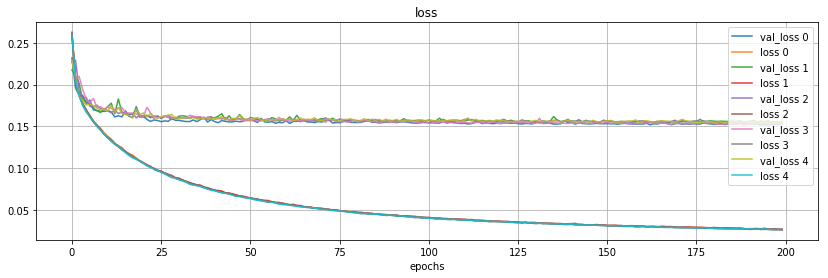

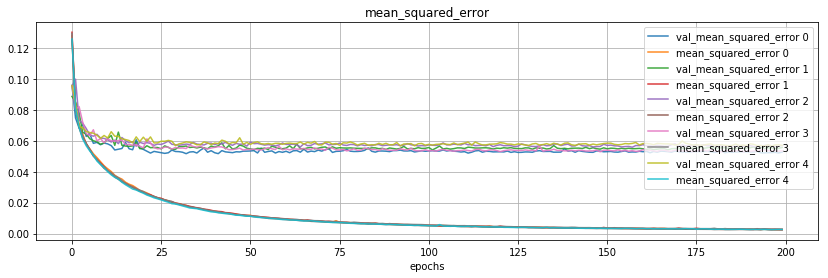

In [21]:
plot_keras_hist(hists)

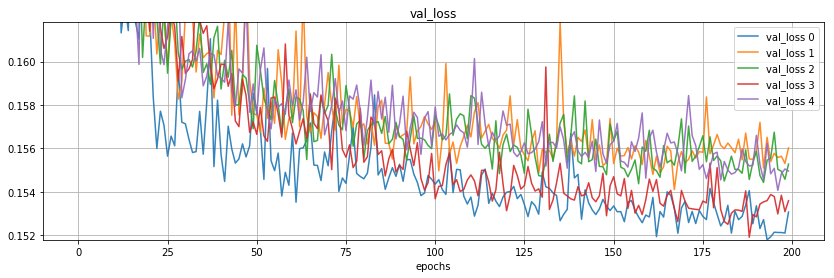

In [22]:
plot_keras_hist(hists, ylim=(min(hists[0].history['val_loss']), 
                             min(hists[0].history['val_loss'])+0.01), metrics_plot=['val_loss'])

### One-fold prediction (haven't run)

In [34]:
params['epochs'] = int(np.mean(best_iterations)*1.15)

In [35]:
params

{'batch_size': 64,
 'epochs': 206,
 'learning_rate': 0.001,
 'n_neurons': (1024, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512),
 'optimizer': keras.optimizers.Adam}

In [36]:
df_train = train.copy()
df_test = test.copy()

# Feature eng
feat_eng = FeatureEngineering(cols_num=cols_num, 
                              cols_cat=cols_cat, 
                              cols_bin=cols_bin, 
                              col_target=col_target, 
                              fillna_values=fillna_values, 
                              cols_right_skew=cols_right_skew,
                              is_embedding=is_embedding, 
                              is_tar_encoded=is_tar_encoded,
                              rare_village_threshold=rare_village_threshold, 
                              rare_town_threshold=rare_town_threshold,)
df_train = feat_eng.fit_transform(df_train, df_test)
df_test = feat_eng.transform(df_test)

# Construct X y matrices
if is_embedding:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
else:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
y_train = df_train[col_target+'_scaled']

# Compute network size
n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
if is_embedding:
    cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
    cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
else:
    cat_n_classes = {}
    cat_embed_sizes = {}
print('Numerical input dims:', n_cols_num_bin)
print('Embeding  input dims:', cat_n_classes)
print('Embeding output dims:', cat_embed_sizes)
print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

# Build model
model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, 
                    n_neurons=params['n_neurons'], learning_rate=params['learning_rate'], 
                    optimizer=params['optimizer'])

# Train model
hist = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'], 
                 verbose=2)

# Predict on test set
df_test[col_target+'_scaled_pred'] = model.predict(X_test, batch_size=1024)
feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')
df_test['total_price_pred'] = post_processing(df_test[col_target+'_pred'], df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': df_test['total_price_pred']})
display(df_test_pred.head(20))

Numerical input dims: 205
Embeding  input dims: {'building_material': 10, 'city': 12, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'town': 209, 'village': 2667, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'city': 6, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'town': 11, 'village': 16, 'encoded_latlon': 5}
Total embedding output dims: 56
Epoch 1/206
 - 120s - loss: 0.2651 - mean_squared_error: 0.1342
Epoch 2/206
 - 118s - loss: 0.2052 - mean_squared_error: 0.0806
Epoch 3/206
 - 118s - loss: 0.1876 - mean_squared_error: 0.0691
Epoch 4/206
 - 118s - loss: 0.1766 - mean_squared_error: 0.0627
Epoch 5/206
 - 121s - loss: 0.1686 - mean_squared_error: 0.0577
Epoch 6/206
 - 121s - loss: 0.1620 - mean_squared_error: 0.0536
Epoch 7/206
 - 121s - loss: 0.1553 - mean_squared_error: 0.0500
Epoch 8/206
 - 122s - loss: 0.1485 - mean_squared_error: 0.0468
Epoch 9/206
 - 124s - loss: 0.1438 - mean_squared_error: 0.0443
Epoch 10/206
 - 126s - loss: 0.138

Epoch 121/206
 - 119s - loss: 0.0340 - mean_squared_error: 0.0042
Epoch 122/206
 - 119s - loss: 0.0343 - mean_squared_error: 0.0042
Epoch 123/206
 - 125s - loss: 0.0350 - mean_squared_error: 0.0042
Epoch 124/206
 - 120s - loss: 0.0343 - mean_squared_error: 0.0041
Epoch 125/206
 - 119s - loss: 0.0336 - mean_squared_error: 0.0041
Epoch 126/206
 - 119s - loss: 0.0329 - mean_squared_error: 0.0040
Epoch 127/206
 - 118s - loss: 0.0333 - mean_squared_error: 0.0040
Epoch 128/206
 - 118s - loss: 0.0335 - mean_squared_error: 0.0040
Epoch 129/206
 - 118s - loss: 0.0323 - mean_squared_error: 0.0039
Epoch 130/206
 - 118s - loss: 0.0326 - mean_squared_error: 0.0039
Epoch 131/206
 - 118s - loss: 0.0333 - mean_squared_error: 0.0040
Epoch 132/206
 - 118s - loss: 0.0332 - mean_squared_error: 0.0040
Epoch 133/206
 - 118s - loss: 0.0325 - mean_squared_error: 0.0039
Epoch 134/206
 - 118s - loss: 0.0324 - mean_squared_error: 0.0039
Epoch 135/206
 - 118s - loss: 0.0327 - mean_squared_error: 0.0039
Epoch 136/

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.568054e+07
1,BTshNOJyKHnT2YIT,4.024808e+06
2,dhdymr0lV8N5kZOT,1.232749e+07
3,VEwyGGMcD56w5BOc,6.866298e+06
4,wmUeMoJZfsqaSX9b,1.040580e+06
5,EtBjGAHmHCe9t7TZ,2.001168e+06
6,hPNH34vmaZtvBtqc,1.265585e+07
7,wXjeI38bYDMJJwZC,6.341510e+06
8,fxZSGX6aPAFKU8W4,1.719071e+06
9,ewr0Fx6ign87OwaV,4.463393e+06


In [37]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

### Result

Round 2:

(('epochs', 200), ('n_neurons', (1024, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 64)) 5010.503401721518 0.052174035 0.15091588 0.011324741 [4954.842085674405, 5003.840687379241, 5072.827432110906] [0.051094234, 0.052469276, 0.0529586] [0.15171897, 0.1507649, 0.15026379] [0.011382295, 0.011312374, 0.011279553]

### Hist

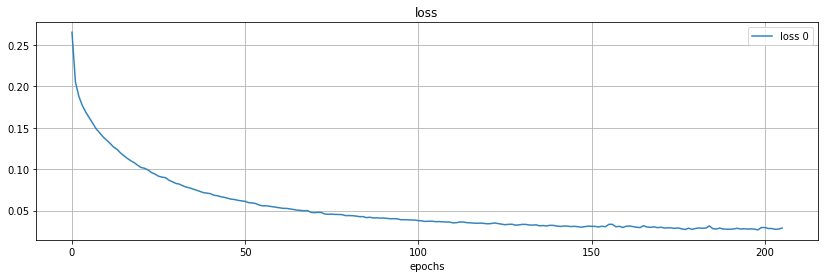

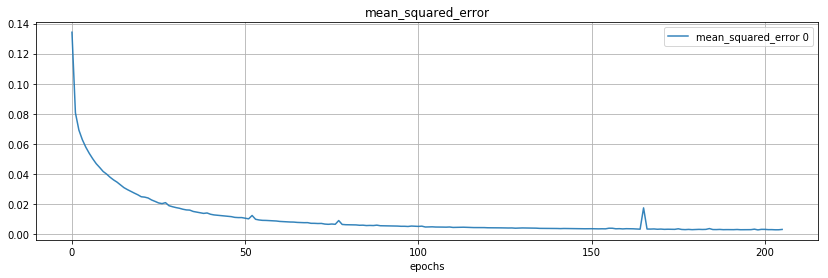

In [38]:
plot_keras_hist(hist)

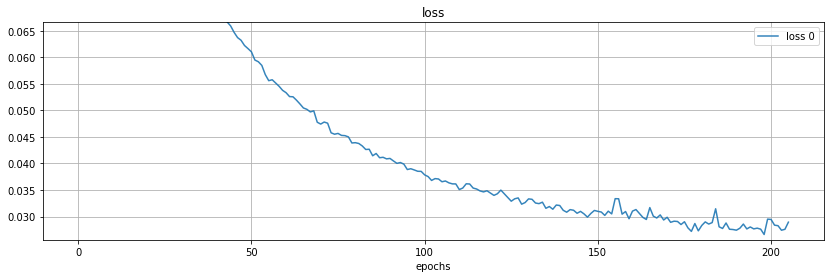

In [42]:
plot_keras_hist(hist, ylim=(min(hist.history['loss'])-0.001, 
                            min(hist.history['loss'])+0.04), metrics_plot=['loss'])